In [99]:
import scipy.stats as sts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

# Estimators
def nonParametricOptimalQuantity(distributionData, tau):
    optimalQuantity = np.quantile(distributionData,tau)
    return optimalQuantity

def profit(tau, demand, quantity):
    price = 1
    cost = 1 - tau
    return price * np.minimum(demand,quantity) - cost * quantity

def parametricOptimalQuantity(estimators, tau):
    optimalQuantity = sts.norm.ppf(tau, loc = estimators[0], scale = estimators[1])
    return optimalQuantity

def realParametricOptimalQuantity(realParameters, tau):
    # we are using lognormal here for the study
    optimalQuantity = sts.lognorm.ppf(tau, s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"])
    return optimalQuantity

# Evaluation of test statistics functions
def empericalRootMeanSquaredError(m, optimalQuantities, tau, realParameters):
    realOptimalQuantity = realParametricOptimalQuantity(realParameters, tau)
    rmse = np.sqrt(1/m * np.sum((optimalQuantities - realOptimalQuantity)**2))
    return rmse

def empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, tau, realParameters):
    return empericalRootMeanSquaredError(m, nonParametricOptimalQuantitys, tau, realParameters) / empericalRootMeanSquaredError(m, parametricOptimalQuantitys, tau, realParameters)

def empericalServiceLevel(m, optimalQuantities, demand):
    indicatorFunction = np.where(optimalQuantities.T >= np.array(demand), 1, 0)
    return 1 / m * np.sum(indicatorFunction)

def empericalProfitLoss(m, optimalQuantities, demand, tau, realParameters, meanDemand):
    realOptimalQuantity = realParametricOptimalQuantity(realParameters, tau)
    # Is it correct to use the location param as mean?
    profitReal = profit(tau, meanDemand, realOptimalQuantity)
    profitEstimator = profit(tau, demand, optimalQuantities.T)
    return 1 / m * np.sum(np.abs((profitReal - profitEstimator) /  profitReal))

def empericalProfitLossRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand):
    return empericalProfitLoss(m, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand) / empericalProfitLoss(m, parametricOptimalQuantitys, demand, tau, realParameters, meanDemand)

def monteCarlo(m, tau, n, realParameters):
    # Define arrays
    parametricOptimalQuantitys = np.empty((m,1))
    nonParametricOptimalQuantitys = np.empty((m,1))
    allParameters = np.empty((m,2))

    meanDemand = sts.lognorm.mean(s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"])
    
    # Compute estimators and optimal quantities
    for j in range(m):
        # Distribution is lognorm, we are assuming normal in the analysis
        distributionData = sts.lognorm.rvs(s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"], size = n)
        allParameters[j] = parameters = sts.norm.fit(distributionData)
        parametricOptimalQuantitys[j] = parametricOptimalQuantity(parameters, tau)
        nonParametricOptimalQuantitys[j] = nonParametricOptimalQuantity(distributionData, tau)
    
    demand = allParameters[:,0] # in case of normal
    # Compute evaluation statistics
    rmse = empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, tau, realParameters)
    eslParametric = empericalServiceLevel(m, parametricOptimalQuantitys, demand)
    eslNonParametric = empericalServiceLevel(m, nonParametricOptimalQuantitys, demand)
    eplr = empericalProfitLossRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand)
    result = {
                    'MonteCarlo iterations' : m,
                    'Sample Size': n,
                    'Target Service Level': tau,
                    'Param Values': np.mean(allParameters, axis=0),
                    'RMSE Ratio': rmse,
                    'SL nonParam': eslParametric,
                    'SL Param': eslNonParametric,
                    'EPLR': eplr
                }
    return result

In [100]:
numberOfMontecarloIterations = 1000

parameters = {"shape": 0.3 , "location" : 65, "scale" : 60}
log_mean = np.log(abs(parameters["location"])) + 0.5 * parameters["shape"]**2
log_std = np.sqrt(np.log(1 + (parameters["shape"]**2)))

tauArray = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
nArray = [10, 50, 100, 200]

results = []
for tau in tauArray:
    for n in nArray:
        result = monteCarlo(numberOfMontecarloIterations, tau, n,parameters)
        results.append(result)

Lognorm normal parameters: mu: 4.219387269895637, std: 0.293560379208524


Code for plotting distributions

Lognorm normal parameters: mu: 4.219387269895637, std: 0.293560379208524


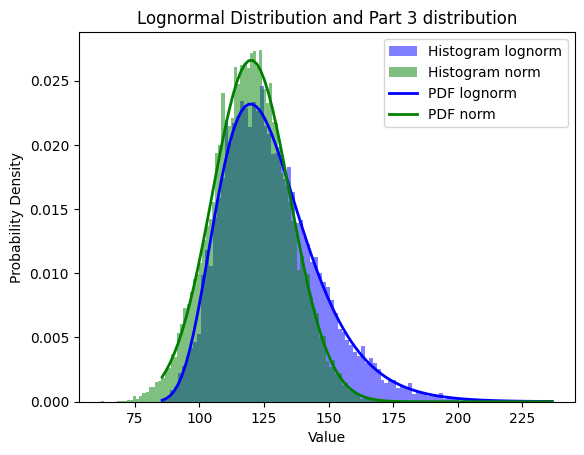

In [112]:
print("Lognorm normal parameters: mu: {0}, std: {1}".format(log_mean,log_std))

dist = sts.lognorm(s=parameters["shape"], loc=parameters["location"], scale=parameters["scale"])
normdist = sts.norm(loc=120, scale=15)

data = dist.rvs(size=10000)
data2 = normdist.rvs(size=10000)

plt.hist(data, bins=100, density=True, alpha=0.5, color='b', label='Histogram lognorm')
plt.hist(data2, bins=100, density=True, alpha=0.5, color='g', label='Histogram norm')

x = np.linspace(np.min(data), np.max(data), 100)
pdf_lognorm = dist.pdf(x)
pdf_norm = normdist.pdf(x)
plt.plot(x, pdf_lognorm, 'b', linewidth=2, label='PDF lognorm')
plt.plot(x, pdf_norm, 'g', linewidth=2, label='PDF norm')

plt.title('Lognormal Distribution and Part 3 distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.legend()
plt.savefig("Excercise part 4/excercise4.pdf")
plt.show()

In [103]:
df = pd.DataFrame(results)
df

,MonteCarlo iterations,Sample Size,Target Service Level,Param Values,RMSE Ratio,SL nonParam,SL Param,EPLR
0,1000,10,0.01,"[127.35266711676175, 17.30089504090558]",0.858692,0.0,0.000,0.938867
1,1000,50,0.01,"[127.76816073838418, 18.81601276278553]",0.381050,0.0,0.000,0.337623
2,1000,100,0.01,"[127.93014201777396, 19.122738858394083]",0.287219,0.0,0.000,0.245423
3,1000,200,0.01,"[127.7477359447212, 19.16875122069872]",0.194213,0.0,0.000,0.161572
4,1000,10,0.05,"[127.86601786769221, 17.43886541774573]",0.962173,0.0,0.000,1.001031
5,1000,50,0.05,"[127.92204195873033, 18.914426012869423]",0.555212,0.0,0.000,0.528291
6,1000,100,0.05,"[127.80215549054834, 19.092669121306084]",0.390388,0.0,0.000,0.343117
7,1000,200,0.05,"[127.80708549708956, 19.18766009475647]",0.286618,0.0,0.000,0.241199
8,1000,10,0.10,"[127.55365125616751, 17.428352758036013]",1.097974,0.0,0.000,1.096318
9,1000,50,0.10,"[127.72891534134985, 18.807730635008458]",0.806589,0.0,0.000,0.783802


Graph data with colours!!!

In [109]:
import plotly.express as px
fig = px.scatter(df, x='Target Service Level', y='RMSE Ratio', color="Sample Size", title="TSL vs RMSE, incorrectly specified model<br><sup>higher RMSE means parametric performs better</sup>")
fig.update_layout(font_size = 15)
fig.write_image("Excercise part 4/RMSE-lognorm.pdf")
fig.show()

fig = px.scatter(df, x='Target Service Level', y='EPLR', color="Sample Size", title="TSL vs EPLR, incorrectly specified model<br><sup>higher EPLR means parametric performs better</sup>")
fig.update_layout(font_size = 15)
fig.write_image("Excercise part 4/EPLR-lognorm.pdf")
fig.show()

#fig = px.scatter(df, x='Target Service Level', y='RMSE Ratio', color="Sample Size", title="TSL vs RMSE, higher RMSE means parametric performs better")
#fig.show()
